# Quantum Support Vector Machines (QSVM)
Quantum Support Vector Machines is the quantum version of SVM; i.e., a data classification method that separates the data using a hyperplane.

The QSVM algorithm takes these steps:
1. Maps the data into a different hyperspace (since the data may be non-linearly-separable in the original space). For QSVM, it maps the classical data into a Hilbert space.
2. Calculates the kernel matrix:
    - The kernel entries are the fidelities between different feature vectors
    - For QSVM, this is done on a quantum computer.
3. Optimizes the dual problem (this is always done classically):
$$ L_D(\alpha) = \sum_{i=1}^t \alpha_i - \frac{1}{2} \sum_{i,j=1}^t y_i y_j \alpha_i \alpha_j K(\vec{x}_i \vec{x}_j) $$
    - where $t$ is the number of data points
    - the $\vec{x}_i$s are the data points
    - $y_i$ is the label $\in \{-1,1\}$ of each data point
    - $K(\vec{x}_i \vec{x}_j)$ is the kernel matrix element between the $i$ and $j$ data points
    - optimized over the $\alpha$s
    - We expect most of the $\alpha$s to be $0$. The $\vec{x}_i$s that correspond to non-zero $\alpha_i$ are called the support vectors.
4. Predicts unlabeled data by calculating the kernel matrix of the new datum with respect to the support vectors:
$$ \text{Predicted Label}(\vec{s}) = \text{sign} \left( \sum_{i=1}^t y_i \alpha_i^* K(\vec{x}_i , \vec{s}) + b \right) $$
    - where $\vec{s}$ is the data point to be classified
    - $\alpha_i^*$ are the optimized $\alpha$s
    - $b$ is the bias

See reference [[1](#learning)].

## Coding QSVM
We start coding with the relevant imports:

In [ ]:
!pip install -qq -U "classiq[qml]"

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.svm import SVC

from classiq import *

Next, we generate data.

This example takes a 2D input space and a binary classification (i.e., only two groups of data points):

In [2]:
import random

RANDOM_SEED = 0
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

In [3]:
# Importing functions used for this demo, to generate random linearly separable data
from classiq.applications.qsvm.qsvm_data_generation import (
    data_and_labels_to_data_dict,
    data_dict_to_data_and_labels,
    generate_data,
)

# Generate sample data:
sources = np.array([[1.23016026, 1.72327701], [3.20331931, 5.32365722]])

training_input: dict = generate_data(sources=sources)
test_input: dict = generate_data(sources=sources)
predict_input, predict_real_labels = data_dict_to_data_and_labels(
    generate_data(sources=sources)
)

Now we plot the data.

Note that the data is expected to be normalized to within $ 0 $ to $ 2 \pi $.

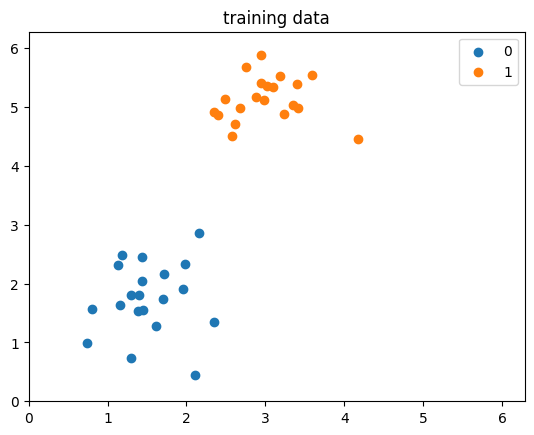

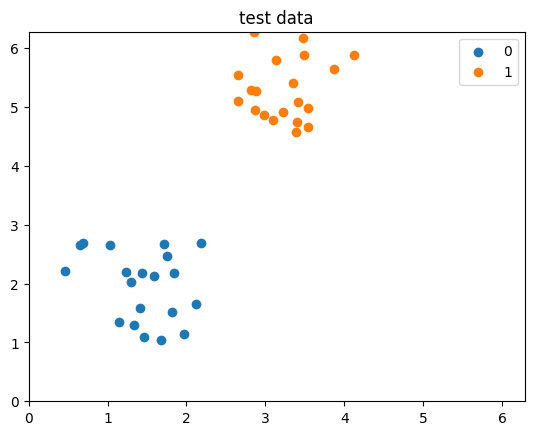

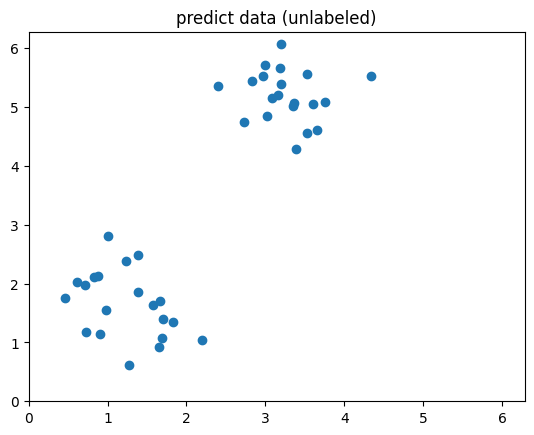

In [4]:
# Plot the data
plot_range = (0, 2 * np.pi)

for k, v in training_input.items():
    plt.scatter(*v.T, label=str(k))
plt.legend()
plt.title("training data")
plt.xlim(plot_range)
plt.ylim(plot_range)
plt.show()

for k, v in test_input.items():
    plt.scatter(*v.T, label=str(k))
plt.legend()
plt.title("test data")
plt.xlim(plot_range)
plt.ylim(plot_range)
plt.show()

plt.scatter(*predict_input.T)
plt.title("predict data (unlabeled)")
plt.xlim(plot_range)
plt.ylim(plot_range)
plt.show()

## Defining the Feature Map
When constructing a `QSVM` model, we must supply the feature map to use.

A feature map is a way to encode classical data into quantum.
Here, we choose to encode the data onto the surface of the Bloch sphere.
This can be defined as
```
R_X(x[0] / 2)
R_Z(x[1])
```
where `x` is the 2D input vector and the circuit takes a single qubit per data point. This creates a state that is  $\cos(x[0]/4)|0\rangle + e^{x[1]/4}\sin(x[0]/4)|1\rangle$ (up to a global phase). We define a quantum function that generalizes the Bloch sphere mapping to an input vector of any dimension (also known as "dense angle encoding" in the field of quantum neural networks). Each pair of entries in the vector is mapped to a Bloch sphere. If there is an odd size, we apply a single RX gate on an extra qubit.

In [5]:
from classiq.qmod.symbolic import ceiling, floor


@qfunc
def bloch_feature_map(data: CArray[CReal], qba: QArray):
    repeat(ceiling(data.len / 2), lambda i: RX(data[2 * i] / 2, qba[i]))
    repeat(floor(data.len / 2), lambda i: RZ(data[(2 * i) + 1], qba[i]))

## Defining the Data
In addition to the feature map, we need to prepare our data.

The `train_input` and `test_input` datasets consisting of data and its labels. The labels are a 1D array where the value of the label corresponds to each data point and can be basically anything, such as (0, 1), (3, 5), or ('A', 'B').
The `predict_input` consists only of data points (without labels).


In [6]:
# Prepare and define `train_input` and `test_input` datasets consisting of data and labels
TRAIN_DATA, TRAIN_LABEL = data_dict_to_data_and_labels(training_input)
TEST_DATA, TEST_LABEL = data_dict_to_data_and_labels(test_input)

# Prepare and define `predict_input`
PREDICT_DATA = predict_input

## Constructing a Model
We can now construct the QSVM model using the `bloch_feature_map` function, and its inverse:

In [7]:
feature_dimension = 2


@qfunc
def main(
    data1: CArray[CReal, feature_dimension],
    data2: CArray[CReal, feature_dimension],
    qba: Output[QNum[ceiling(feature_dimension / 2)]],
):
    allocate(qba)
    bloch_feature_map(data1, qba)
    invert(lambda: bloch_feature_map(data2, qba))


QSVM_BLOCH_SHPERE_qmod = create_model(main, out_file="qsvm")

## Synthesizing the Model and Exploring the Generated Quantum Circuit
Once we have constructed our QSVM model, we synthesize and view the quantum circuit that encodes our data using the Classiq built-in `synthesize` and `show` functions:

In [8]:
qprog = synthesize(QSVM_BLOCH_SHPERE_qmod)
show(qprog)

Quantum program link: https://platform.classiq.io/circuit/32pQdaKz3yY76oVkN4CuYyLNXrl


## Executing QSVM
Steps in QSVM execution:
1. Training.
2. Testing the training process.
3. Predicting, by taking unlabeled data and returning its predicted labels. This may be applied multiple times on different datasets.

Next, we define classical functions for applying the three parts of the execution process, where the third uses `ExecutionSession` and `batch_sample`.

In [9]:
def get_execution_params(data1, data2=None):
    """
    Generate execution parameters based on the mode (train or validate).

    Parameters:
    - data1: First dataset (used for both training and validation).
    - data2: Second dataset (only required for validation).

    Returns:
    - A list of dictionaries with execution parameters.
    """
    if data2 is None:
        # Training mode (symmetric pairs of data1)
        return [
            {"data1": data1[k], "data2": data1[j]}
            for k in range(len(data1))
            for j in range(k, len(data1))  # Avoid symmetric pairs
        ]
    else:
        # Prediction mode
        return [
            {"data1": data1[k], "data2": data2[j]}
            for k in range(len(data1))
            for j in range(len(data2))
        ]


def construct_kernel_matrix(matrix_size, res_batch, train=False):
    """
    Construct a kernel matrix from `res_batch`, depending on whether it's for training or predicting.

    Parameters:
    - matrix_size: Tuple of (number of rows, number of columns) for the matrix.
    - res_batch: Precomputed batch results.
    - train: Boolean flag. If True, assumes training (symmetric matrix).

    Returns:
    - A kernel matrix as a NumPy array.
    """
    rows, cols = matrix_size
    kernel_matrix = np.zeros((rows, cols))

    num_shots = res_batch[0].num_shots
    num_output_qubits = len(next(iter(res_batch[0].counts)))

    count = 0
    if train:  # and rows == cols:
        # Symmetric matrix (training)
        for k in range(rows):
            for j in range(k, cols):
                value = (
                    res_batch[count].counts.get("0" * num_output_qubits, 0) / num_shots
                )
                kernel_matrix[k, j] = value
                kernel_matrix[j, k] = value  # Use symmetry
                count += 1
    else:
        # Non-symmetric matrix (validation)
        for k in range(rows):
            for j in range(cols):
                kernel_matrix[k, j] = (
                    res_batch[count].counts.get("0" * num_output_qubits, 0) / num_shots
                )
                count += 1

    return kernel_matrix


def train_svm(es, train_data, train_labels):
    """
    Trains an SVM model using a custom precomputed kernel from the training data.

    Parameters:
    - es: ExecutionSession object to process batch execution for kernel computation.
    - train_data: List of data points for training.
    - train_labels: List of binary labels corresponding to the training data.

    Returns:
    - svm_model: A trained SVM model using the precomputed kernel.
    """
    train_size = len(train_data)
    train_execution_params = get_execution_params(train_data)
    res_train_batch = es.batch_sample(train_execution_params)  # execute batch
    # generate kernel matrix for train
    kernel_train = construct_kernel_matrix(
        matrix_size=(train_size, train_size), res_batch=res_train_batch, train=True
    )
    svm_model = SVC(kernel="precomputed")
    svm_model.fit(
        kernel_train, train_labels
    )  # the fit gets the precomputed matrix of training, and the training labels

    return svm_model


def predict_svm(es, data, train_data, svm_model):
    """
    Predicts labels for new data using a precomputed kernel with a trained SVM model.

    Parameters:
    - es: ExecutionSession object to process batch execution for kernel computation.
    - data (list): List of new data points to predict.
    - train_data (list): Original training data used to train the SVM.
    - svm_model: A trained SVM model returned by `train_svm`.

    Returns:
    - y_predict (list): Predicted labels for the input data.
    """
    predict_size = len(data)
    train_size = len(train_data)
    predict_execution_params = get_execution_params(data, train_data)
    res_predict_batch = es.batch_sample(predict_execution_params)  # execute batch
    kernel_predict = construct_kernel_matrix(
        matrix_size=(predict_size, train_size), res_batch=res_predict_batch, train=False
    )
    y_predict = svm_model.predict(
        kernel_predict
    )  # the predict gets the precomputed test matrix

    return y_predict

We can now run the execution session with all three parts:

In [10]:
from classiq.execution import ExecutionSession

with ExecutionSession(qprog) as es:
    # train
    svm_model = train_svm(es, TRAIN_DATA.tolist(), TRAIN_LABEL.tolist())

    # test
    y_test = predict_svm(es, TEST_DATA.tolist(), TRAIN_DATA.tolist(), svm_model)
    test_score = sum(y_test == TEST_LABEL.tolist()) / len(TEST_LABEL.tolist())

    # predict
    predicted_labels = predict_svm(
        es, PREDICT_DATA.tolist(), TRAIN_DATA.tolist(), svm_model
    )

We can view the classification accuracy through `test_score`:

In [11]:
print("quantum kernel classification test score:  %0.2f" % (test_score))

quantum kernel classification test score:  1.00


Since this data was previously generated, we also know the real labels and can print them for comparison.

In [12]:
print(predicted_labels)
print(predict_real_labels)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1]


We can even visualize the predicted results:

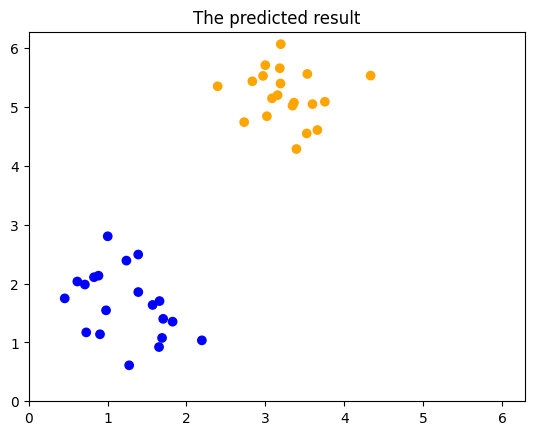

In [13]:
# Plotting
COLORS = ["blue", "orange"]
plt.scatter(
    *zip(*predict_input),
    color=np.vectorize(COLORS.__getitem__)(predicted_labels),
)
plt.title("The predicted result")
plt.xlim(plot_range)
plt.ylim(plot_range)
plt.show()

## Reference

<a id='learning'>[1]</a> [Havl&#237;&#269;ek, V., C&#243;rcoles, A.D., Temme, K. et al. Supervised learning with quantum-enhanced feature spaces. Nature 567, 209-212 (2019).](https://doi.org/10.1038/s41586-019-0980-2)